# CSE 572: Lab 14

Cluster analysis seeks to partition the input data into groups of closely related instances so that instances that belong to the same cluster are more similar to each other than to instances that belong to other clusters. In this lab, you will practice implementing the K-means clustering technique. 

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Load the dataset

We will start by loading the MNIST handwritten digits dataset. This dataset contains 8x8 grayscale images of handwritten digits from 0 to 9. Our goal in using clustering is to group images such that the handwritten digits on the images within each cluster are the same. Note: we do not split the dataset into train/val/test subsets because we are not doing classification. 

In [ ]:
import numpy as np
seed = 0
np.random.seed(seed)
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)

In [ ]:
data.shape

(1797, 64)

Print the number of samples and attributes in the dataset.

In [ ]:
# YOUR CODE HERE
print("No of samples are", len(labels), " and no of attributes are", data.shape[1])

No of samples are 1797  and no of attributes are 64


To get an idea of what is in our dataset, write code to visualize a random image from each class below. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


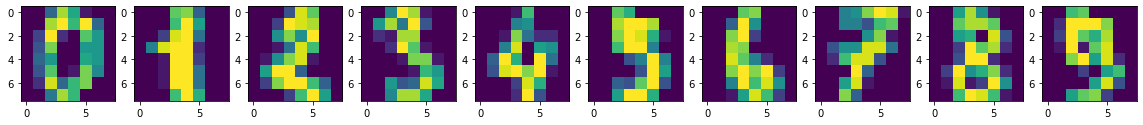

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
fig, axes = plt.subplots(ncols=10, nrows=1, figsize=(20,20))
l=pd.DataFrame(labels)
l1=l.groupby(0)
for i in range(10): 
  l2=l1.get_group(i) 
  a=l2.sample()
  axes[i].imshow(data[:][a].reshape((8,8)), interpolation="none")

Next we standardize the data so that the mean of all attributes is 0 using the StandardScaler() class in scikit-learn to standardize the data. 

In [ ]:
data_rshp = data.reshape([1797,8,8])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

## K-means Clustering

The k-means clustering algorithm represents each cluster by its corresponding cluster centroid. The algorithm partitions the input data into *k* disjoint clusters by iteratively applying the following two steps:
1. Form *k* clusters by assigning each instance to its nearest centroid.
2. Recompute the centroid of each cluster.

We will first implement the standard K-means algorithm with randomly initialized centroids. We'll use 10 clusters because we have 10 classes and our goal is that each cluster contains mostly images from the same class.

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 10

k_means = KMeans(n_clusters=n_clusters, init='random', n_init=1, random_state=seed)
k_means.fit(data)

KMeans(init='random', n_clusters=10, n_init=1, random_state=0)

The `k_means.labels_` attribute contains the cluster labels assigned to each of our data samples. It is an array of integers representing the cluster number (starting from 0).

In [ ]:
clusters = k_means.labels_

clusters

array([7, 1, 1, ..., 1, 8, 8], dtype=int32)

One way to evaluate how good our clustering was is to assess the homogeneity of classes in each cluster, since we know the class labels of this dataset. Below, we plot 10 examples randomly drawn from each of the 10 clusters. We plot the true class of each image in the title.

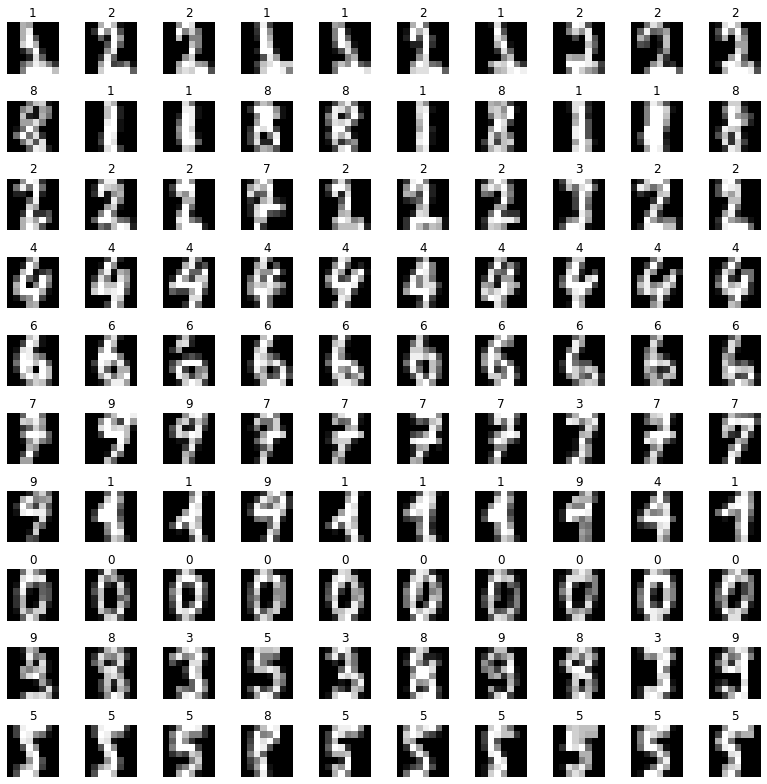

In [ ]:
n_vis = 10
n_digits=n_clusters
fig, axes = plt.subplots(ncols=n_vis, nrows=n_clusters, figsize=(11,11))

for i in range(n_digits):
    rand_inds = np.random.randint(0, clusters[clusters==i].shape[0], size=n_vis)
    for j in range(n_vis):
        axes[i,j].imshow(data_rshp[clusters==i][rand_inds[j]].astype(np.uint8), cmap='gray')
        axes[i,j].set_title(labels[clusters==i][rand_inds[j]])
        axes[i,j].axis('off')
        
fig.tight_layout()

Looking at the homogeneity of classes in these sample subsets, we can see that the clustering was not perfect but appears to be pretty good. We can quantify this using the homogeneity score.

A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class. This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

We compute the homogeneity score below.

In [ ]:
from sklearn.metrics import homogeneity_score

kmeans_homog = homogeneity_score(labels, clusters)
print('K-means homogeneity score: %f' % kmeans_homog)

K-means homogeneity score: 0.665576


We can also evaluate multiple algorithms by comparing the "inertia" aka "cohesiveness" aka sum of squared errors of the points within each resulting cluster. This is stored in the `inertia_` attribute.

In [ ]:
print('K-means inertia: %f' % k_means.inertia_) 

K-means inertia: 70668.011798


## K-means++

K-means++ is a modified version of the K-means algorithm that chooses initial centroids to be far apart, instead of randomly choosing initial centroids. Read the [scikit-learn documentation for K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to figure out how to implement K-means++. Hint: this involves setting a specific argument.

Fit a K-means++ model for 10 clusters then compute the homogeneity score of the resulting clusters. 

In [ ]:
# YOUR CODE HERE

from sklearn.cluster import KMeans

n_clusters = 10

k_means_pp = KMeans(n_clusters=n_clusters, init='k-means++',  random_state=seed)
k_means_pp.fit(data)

from sklearn.metrics import homogeneity_score
clusters = k_means_pp.labels_
kmeans_homog_pp = homogeneity_score(labels, clusters)
print('K-means homogeneity score: %f' % kmeans_homog_pp)

K-means homogeneity score: 0.601721


Additionally, print the inertia of the clustering resulting from K-means++.

In [ ]:
# YOUR CODE HERE
print('K-means inertia: %f' % k_means_pp.inertia_) 

K-means inertia: 69437.297822


## K-means + PCA

In previous lectures, we learned that dimensionality reduction techniques could be used for visualizing high-dimensional datasets in addition to being used to transform data into new features for classification. In this section, we will demonstrate using PCA for both purposes. 

First, we demonstrate below how to use PCA to visualize our 64-dimensional dataset in two dimensions.

In [ ]:
from sklearn.decomposition import PCA

data_pca = PCA(n_components=2).fit_transform(data)

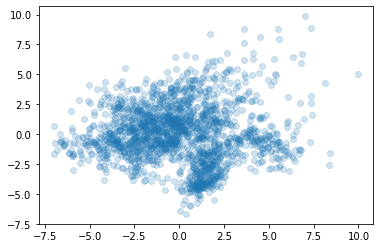

In [ ]:
plt.scatter(data_pca[:,0], data_pca[:,1], alpha=0.2)

We can visualize the clusters learned by K-means and K-means++ by coloring the points in the above plot by their cluster ID from each algorithm.

Text(0.5, 1.0, 'K-means++ clusters')

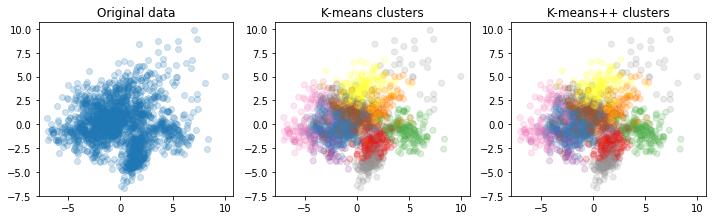

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))
fig.tight_layout()

ax[0].scatter(data_pca[:,0], data_pca[:,1], alpha=0.2)
ax[0].set_title('Original data')

ax[1].scatter(data_pca[:,0], data_pca[:,1], alpha=0.2, c=clusters, cmap='Set1')
ax[1].set_title('K-means clusters')

ax[2].scatter(data_pca[:,0], data_pca[:,1], alpha=0.2, c=k_means_pp.labels_, cmap='Set1')
ax[2].set_title('K-means++ clusters')

Note that even though we colored the points in PCA space by their cluster ID above, the points were clustered in the *original* feature space (not the PCA feature space). 

Next, we will use PCA to reduce the data dimensionality and transform the data into new attributes before clustering. Fit a new K-means++ model to cluster the data in the principal subspace. 

In [ ]:
data_pca

array([[ 1.91421462, -0.95448982],
       [ 0.58898054,  0.92461521],
       [ 1.30203929, -0.31722966],
       ...,
       [ 1.02259567, -0.14791108],
       [ 1.07605404, -0.38092232],
       [-1.25770642, -2.22756523]])

In [ ]:
# YOUR CODE HERE

from sklearn.cluster import KMeans

n_clusters = 10

k_means_pca = KMeans(n_clusters=n_clusters, init='k-means++',   random_state=seed)
k_means_pca.fit(data_pca)


KMeans(n_clusters=10, random_state=0)

Visualize the clusters by adding another subplot to the previous plot that visualizes the clustering from K-means++ after first applying PCA.

Text(0.5, 1.0, 'pca+K-means++ clusters')

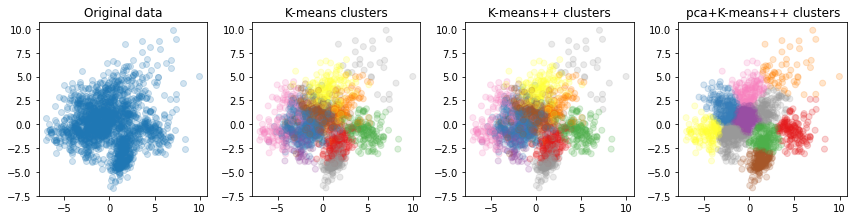

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(12,3))
fig.tight_layout()

ax[0].scatter(data_pca[:,0], data_pca[:,1], alpha=0.2)
ax[0].set_title('Original data')

ax[1].scatter(data_pca[:,0], data_pca[:,1], alpha=0.2, c=clusters, cmap='Set1')
ax[1].set_title('K-means clusters')

ax[2].scatter(data_pca[:,0], data_pca[:,1], alpha=0.2, c=k_means_pp.labels_, cmap='Set1')
ax[2].set_title('K-means++ clusters')


ax[3].scatter(data_pca[:,0], data_pca[:,1], alpha=0.2, c=k_means_pca.labels_, cmap='Set1')
ax[3].set_title('pca+K-means++ clusters')

# YOUR CODE HERE

Next, compute the homogeneity score and the inertia for the PCA + Kmeans++ clustering.

In [ ]:
# YOUR CODE HERE
from sklearn.metrics import homogeneity_score
clusters = k_means_pca.labels_
kmeans_homog_pca = homogeneity_score(labels,clusters)
print('K-means homogeneity score: %f' % kmeans_homog_pca)

K-means homogeneity score: 0.457456


In [ ]:
# YOUR CODE HERE
print('K-means inertia: %f' % k_means_pca.inertia_) 

K-means inertia: 2816.629699


**Question 1: Which clustering had the best performance in terms of homogeneity score? Which clustering resulted in the lowest inertia (sum of squared distances of samples to their closest cluster center)?**

**Answer:**

The kmeans++ with pca has the best performance and that resulted in lowest inertia.

**Question 2: Is the homogeneity score or the inertia (SSE) a better metric for choosing the best clustering? Why?**

**Answer:**

Homogenity is a better metric as intertia is a good metric only for spherical structured clusters,Also inertia is unbounded and will depend on the dataset and how it is structured while homogeneity is absolute and can be used in comparing between diff datasets and models


## Choosing the number of clusters

In the previous examples, we used 10 clusters because we knew there were 10 classes in the dataset. However, in many use cases for clustering, we don't know which classes or how many classes are in the data, so we need a way of choosing the number of clusters to use.

To demonstrate these techniques, we will create a toy 2-dimensional dataset of blobs. 

In [ ]:
from sklearn.datasets import make_blobs

np.random.seed(seed)
X, _ = make_blobs(n_samples=100, centers=np.random.randint(2, 11), n_features=2, random_state=seed)

Text(0, 0.5, 'x2')

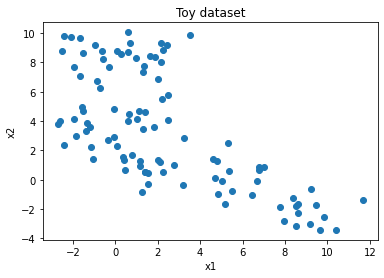

In [ ]:
# Visualize the dataset

plt.scatter(X[:,0], X[:,1])
plt.title('Toy dataset')
plt.xlabel('x1')
plt.ylabel('x2')

**Question 3: How many clusters do you think is the ideal number of clusters for this dataset? Restrict your answer to numbers between 1 and 10.**

**Answer:**

4

To determine the number of clusters in the data, we can apply k-means with varying number of clusters from 1 to 10 and compute their corresponding sum-of-squared errors (SSE) as shown in the example below. The "elbow" in the plot of SSE versus number of clusters can be used to estimate the number of clusters.

Text(0, 0.5, 'SSE')

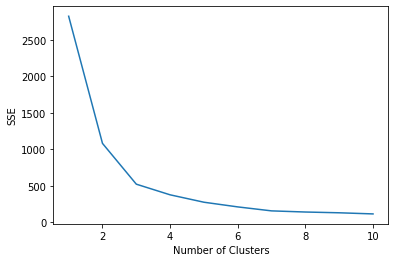

In [ ]:
num_clusters = range(1, 11)
sse = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(num_clusters, sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

Fit a K-means++ classifier to this dataset. Choose $k$ based on the "elbow" location in the plot above. Note that scikit-learn initializes centroids using the K-means++ algorithm by default, so this was used in the previous cell too. In practice, K-means is used to describe random and K-means++ initialization of centroids interchangeably, so we will continue referring to both as simply "K-means". 

In [ ]:
# YOUR CODE HERE
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, init='k-means++',n_init=1,  random_state=seed)
kmeans.fit(X)


KMeans(n_clusters=3, n_init=1, random_state=0)

Finally, plot the toy dataset colored by the resulting clusters.

Text(0, 0.5, 'x2')

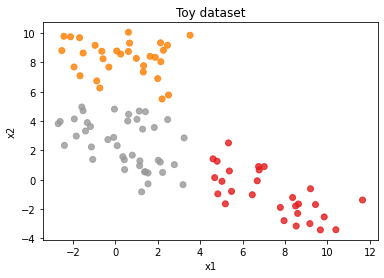

In [ ]:
# Visualize the dataset

plt.scatter(X[:,0], X[:,1], alpha=0.8, c=kmeans.labels_, cmap='Set1')
plt.title('Toy dataset')
plt.xlabel('x1')
plt.ylabel('x2')

**Question 4: Was your guess from Question 3 the same as the number of clusters you chose based on the SSE plot? Why or why not?**

**Answer:**

No, my guess was 4 while the elbow method gave 3 as the optimal number of clusters. Since there was some gap inbetween 2 clusters in red clsuters, i thought of conisdering it as a seprate cluster.

In [ ]:
print('K-means inertia: %f' % kmeans.inertia_) 

K-means inertia: 523.275413
